In [1]:
#! pip install tf-keras
#! pip install wordcloud

In [2]:
# https://www.geeksforgeeks.org/nlp/sentiment-classification-using-bert/
# This notebook is based on movie reviews 

import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")

wd="C:/Users/swati/Desktop/anaconda/BERT sentiment analysis/"
os.chdir(wd)

### 1. Download training data from the internet

In [ ]:
# download the training data from internet
'''
dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  wd,
    extract = True)
'''

In [3]:
dataset="C:/Users/swati/Desktop/anaconda/BERT sentiment analysis/datasets/"
dataset_path = os.path.dirname(dataset)
dataset_dir = os.path.join(dataset_path, 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

### 2. Create the dataset in review and sentiment format

In [5]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
       # print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
            
    return pd.DataFrame.from_dict(data)

In [6]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

                                            sentence  sentiment
0  Story of a man who has unnatural feelings for ...          0
1  Airport '77 starts as a brand new luxury 747 p...          0
2  This film lacked something I couldn't put my f...          0
3  Sorry everyone,,, I know this is supposed to b...          0
4  When I was little my parents took me along to ...          0


In [8]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

                                            sentence  sentiment
0  I've read the book 'Scarlett' and was expectin...          0
1  As everyone knows, nobody can play Scarlett O'...          0
2  If you really loved GWTW, you will find quite ...          0
3  Shwaas may have a good story, but the director...          0
4  This is not a good movie at all. I cannot beli...          0


In [10]:
sentiment_counts = train_df['sentiment'].value_counts()
sentiment_counts

sentiment
0    12500
1    12500
Name: count, dtype: int64

In [11]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [12]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

In [13]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

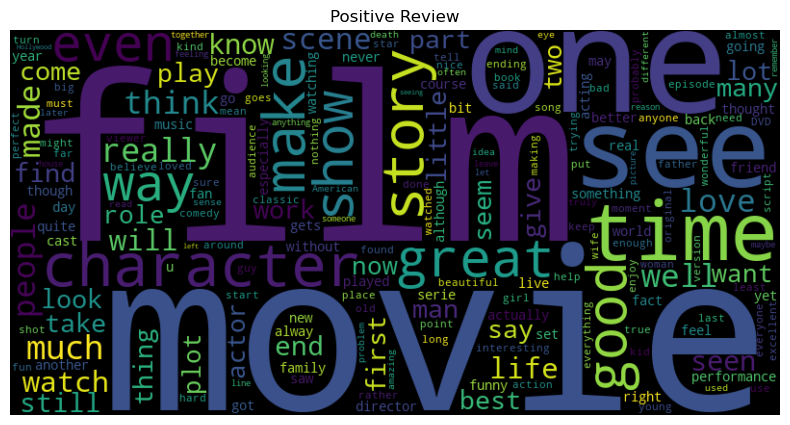

In [14]:
positive = train_df.loc[train_df['sentiment']==1,'Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

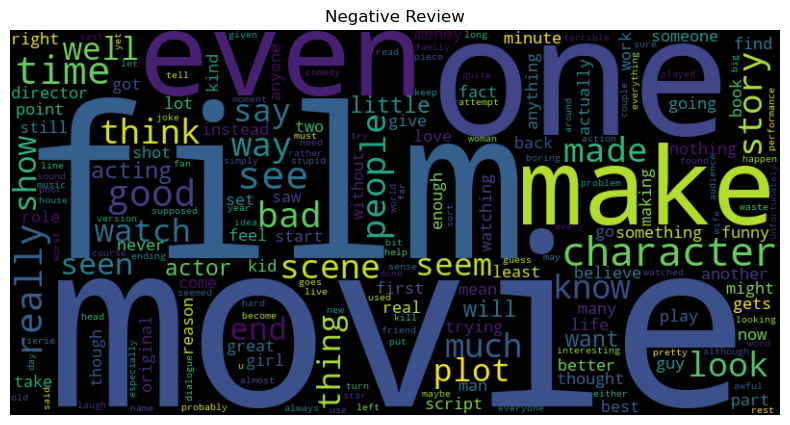

In [15]:
negative = train_df.loc[train_df['sentiment']==0,'Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [16]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [17]:
# split test into test and validation data sets
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)


### 3. Load the bert tokenizer

In [18]:
# load the bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [20]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Story of a man who has unnatural feelings for a pig Starts out with a opening scene that is a terrific example of absurd comedy A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting Even those from the era should be turned off The cryptic dialogue would make Shakespeare seem easy to a third grader On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond Future stars Sally Kirkland and Frederic Forrest can be seen briefly

Input Ids -->>
 tf.Tensor(
[  101  2466  1997  1037  2158  2040  2038 21242  5346  2005  1037 10369
  4627  2041  2007  1037  3098  3496  2008  2003  1037 27547  2742  1997
 18691  4038  1037  5337  4032  4378  2003  2357  2046  2019  9577  1010
  6355 11240  2011  1996  4689 22417  2015  1997  2009  1005  1055  8453
  6854  2

In [21]:
X_train_encoded['input_ids'].shape

TensorShape([25000, 128])

### 4. Load and compile the model for inference 

In [35]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [38]:
# Train the model (will take a lot of time) 
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=1
    #epochs=3
)

  7/782 [..............................] - ETA: 2872:54:15 - loss: 0.7167 - accuracy: 0.4955

KeyboardInterrupt: 

In [ ]:
# evaluate model (will take a lot of time)

#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

### 4.1 Save and load the trained model once only 

In [ ]:
path = '/content'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [ ]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

### 5. Predict on test data

In [25]:
# update to bert_model
pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

 22/330 [=>............................] - ETA: 54:09


KeyboardInterrupt



### 6. Classification metrics

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_valid,valid_pred)

In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


### 6. Predict with user inputs

In [29]:
# update to bert_model bert_tokenizer
def Get_sentiment(Review, Tokenizer=tokenizer, Model=model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    
    label = {
    1: 'positive',
    0: 'Negative'
    }

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [30]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015. 
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love. 
The movie has received rave reviews from critics and audiences alike for its stunning visuals, 
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)

1/1 [==============================] - 0s 378ms/step


['positive']

In [33]:
Review ='''Hungama is  a bollywood series which started in 2000 and is a very bad movie '''
Get_sentiment(Review)

1/1 [==============================] - 0s 146ms/step


['positive']